# Imports and Data Loading

In [5]:
#DEFINE MODEL VERSION
CODE_VERSION = "V1"

# Standard library imports
import os
import math
from datetime import datetime

# Third-party package imports for data manipulation
import pandas as pd
import numpy as np

# PyTorch imports for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Visualization and logging tools
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb  # Weights & Biases for experiment tracking

# Custom modules
from autoencoder import weights_init, AutoencoderV1, AutoencoderV2, AutoencoderV3, AutoencoderV4

# Configure environment variables for Weights & Biases
os.environ["WANDB_SILENT"] = "true"
os.environ['WANDB_DISABLE_CODE']='True'

# Initialize Weights & Biases
wandb.login()

# Set the device for PyTorch (CPU in this case)
device = torch.device("cpu")

In [2]:
# Load the data
data = pd.read_csv('data/skew_corr_group.csv')
data.fillna(0, inplace=True)

# Convert DataFrame to numpy array and then to PyTorch tensor
tensor = torch.tensor(data.values, dtype=torch.float32)
dataset = TensorDataset(tensor, tensor)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Training

The choice to use Binary Cross-Entropy (BCE) loss for the autoencoder is quite deliberate. Given that we're dealing with binary symptom data, BCE is particularly apt for evaluating our model's performance. The function effectively quantifies the difference between the predicted and actual binary outcomes. Importantly, it severely penalizes overly confident but incorrect predictions, which makes it a robust choice for binary classification problems like ours.

The Binary Cross-Entropy loss for each data point \( x \) is given by:

$$
\text{BCE}(y, \hat{y}) = - (y \log(\hat{y}) + (1-y) \log(1-\hat{y}))
$$


In [3]:
import os

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def train_autoencoder(model, train_loader, val_loader, epochs=50, CODE_VERSION=""):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    # Variable to keep track of the best validation loss
    best_val_loss = float('inf')
    
    # Make sure the encoder_models/CODE_VERSION directory exists
    ensure_dir(f'encoder_models/{CODE_VERSION}')

    for epoch in tqdm(range(epochs), desc=f'Latent Dim {model.latent_dim}'):
        model.train()
        total_train_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            
            # Save the best model
            save_path = f'encoder_models/{CODE_VERSION}/best_model_latent_dim_{model.latent_dim}.pth'
            torch.save(model.state_dict(), save_path)

    return train_losses, val_losses


## Training Run with Logging

Latent Dim 5: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Latent Dim 10: 100%|██████████| 50/50 [00:06<00:00,  8.24it/s]


Latent Dim 20: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Latent Dim 30: 100%|██████████| 50/50 [00:06<00:00,  8.12it/s]


Latent Dim 40: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Latent Dim 50: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


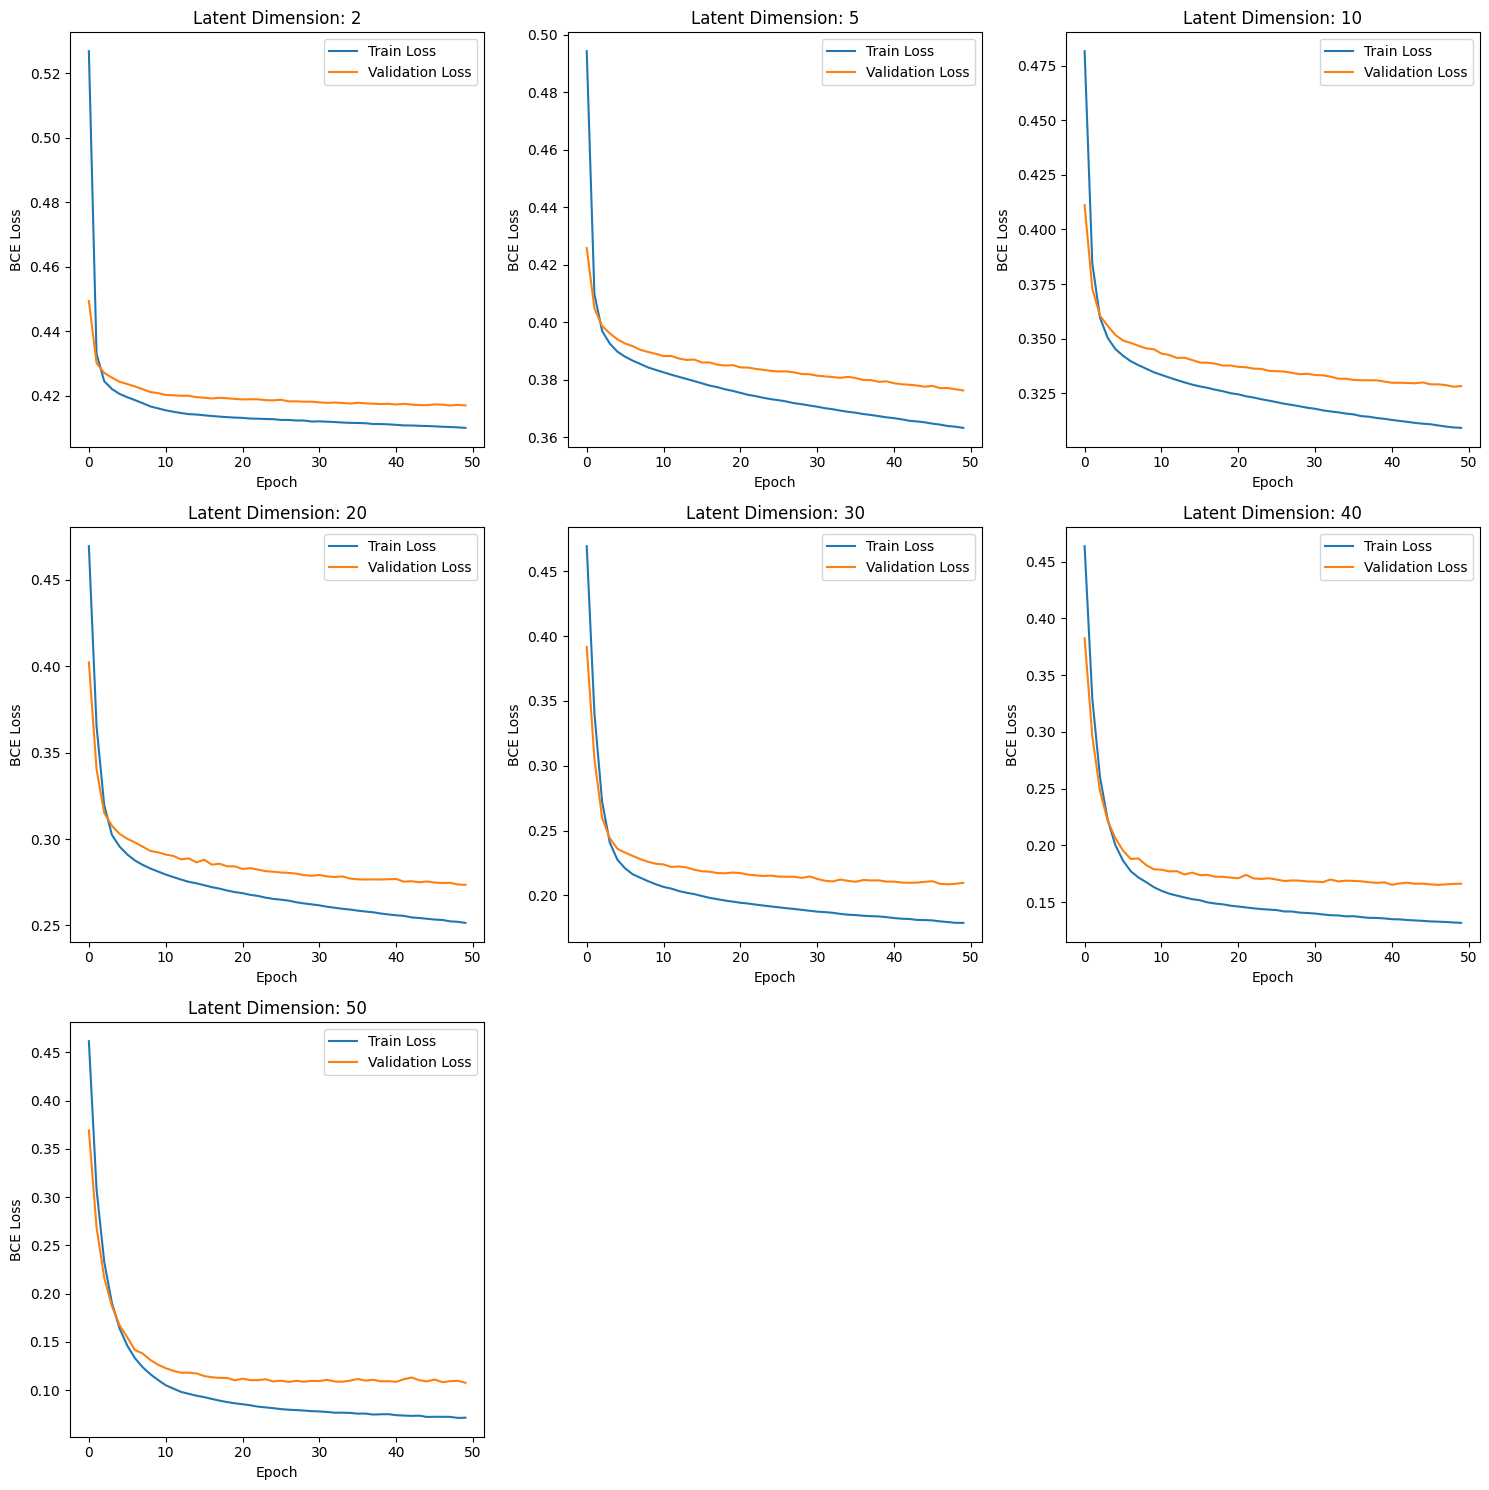

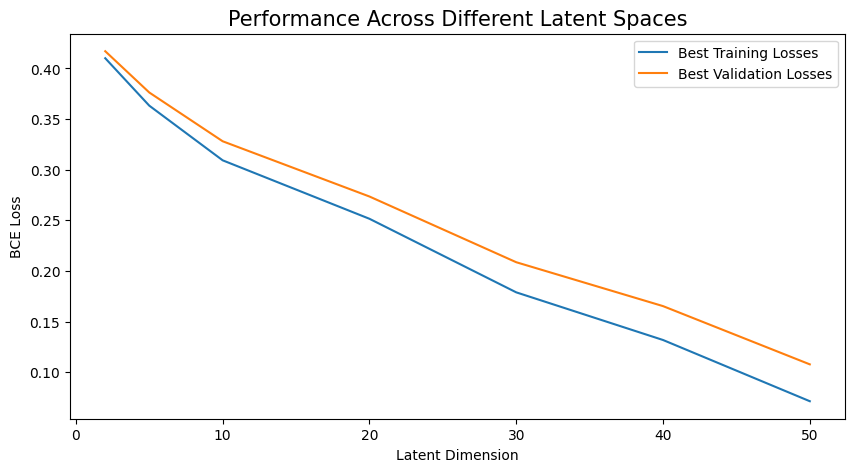

In [4]:
# Generate a timestamp to uniquely identify this run
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

latent_dims = [2, 5, 10, 20, 30, 40, 50]
all_train_losses = []
all_val_losses = []

# Calculating rows and columns for subplots
n = len(latent_dims)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

# Append the timestamp to the group name
group_name = f"Autoencoders_{timestamp}"

for idx, dim in enumerate(latent_dims):
    with wandb.init(project="PLR", tags=["Leo", CODE_VERSION], group=group_name, name=f"latent_dim={dim}", save_code=True) as run:
        wandb.save("autoencoder.py")
        wandb.config.latent_dim = dim  # Log the latent dimension as a hyperparameter

        # Create and train the autoencoder
        try:
            model = eval(f"Autoencoder{CODE_VERSION}(input_dim=data.shape[1], latent_dim=dim)")
        except NameError:
            raise ValueError(f"Invalid code version: {CODE_VERSION}")

        model.apply(weights_init)
        train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, epochs=50, CODE_VERSION=CODE_VERSION)

        all_train_losses.append(min(train_losses))
        all_val_losses.append(min(val_losses))

        # Add back the missing plotting code
        axs[idx].plot(train_losses, label='Train Loss')
        axs[idx].plot(val_losses, label='Validation Loss')
        axs[idx].set_title(f"Latent Dimension: {dim}")
        axs[idx].set_xlabel('Epoch')
        axs[idx].set_ylabel('BCE Loss')
        axs[idx].legend()

        # Log losses to wandb
        for epoch, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            wandb.log({"Train Loss": train_loss, "Validation Loss": val_loss, "epoch": epoch})

# Hide any unused subplots
for idx in range(len(latent_dims), rows * cols):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot overall performance
plt.figure(figsize=(10, 5))
plt.plot(latent_dims, all_train_losses, label='Best Training Losses')
plt.plot(latent_dims, all_val_losses, label='Best Validation Losses')
plt.xlabel('Latent Dimension')
plt.ylabel('BCE Loss')
plt.title('Performance Across Different Latent Spaces', fontsize=15)
plt.legend()
plt.show()


wandb.finish()

# Extract Encoder and Create New Dataframe in Lower Dimension

In [6]:
# Loading the best model
trained_autoencoder = AutoencoderV1(data.shape[1], 2)  
trained_autoencoder.load_state_dict(torch.load('encoder_models/V1/best_model_latent_dim_2.pth'))
trained_autoencoder.eval()

# Extract encoder
encoder = trained_autoencoder.encoder

# Transform original dataset
def transform_data(encoder, original_data_loader):
    transformed_data = []
    
    for batch_idx, (data, _) in enumerate(original_data_loader):
        encoded_data = encoder(data).detach().cpu().numpy()
        transformed_data.append(encoded_data)

    transformed_data = np.vstack(transformed_data)
    return transformed_data

# Create DataLoader for original dataset
original_data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Get the transformed data
transformed_data = transform_data(encoder, original_data_loader)

In [10]:
transformed_data.shape

(6035, 2)

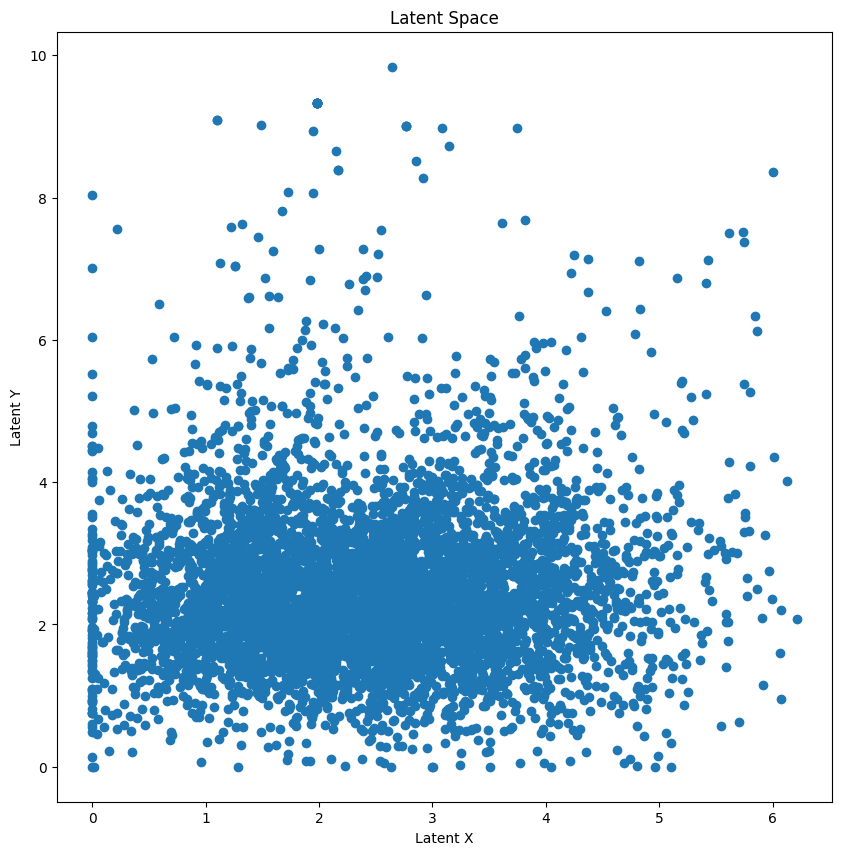

In [11]:
#visualize the data
plt.figure(figsize=(10, 10))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.title('Latent Space')
plt.xlabel('Latent X')
plt.ylabel('Latent Y')
plt.show()